# Twisted Diffusion Model Sampler

This notebook provides a sampler for the trained diffusion model.

In [1]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

# Import project modules
from models.unet import create_unet_model, load_vae, load_classifier, load_clip_model
from schedulers.edm_scheduler import create_edm_scheduler
from utils.edm_utils import edm_clean_image_to_model_input, edm_model_output_to_x_0_hat
from config.default_config import EDM_CONFIG
from models.clip_image_encoder import OpenCLIPVisionEncoder
from data.dataset import FullFieldDataset

/home/pc/anaconda3/envs/image_tds/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up device and configuration

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set precision (you can adjust this based on your hardware)
weight_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# # Define paths to models and checkpoints
# model_path = "/path/to/your/trained/model"  # Update this to your model checkpoint path
# vae_path = "/scratch/groups/emmalu/marvinli/twisted_diffusion/stable-diffusion-3.5-large-turbo/vae"
# classifier_path = "/scratch/groups/emmalu/marvinli/twisted_diffusion/checkpoints_classifier/model_epoch_7.pth"
# clip_model_path = "microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"


# Define paths to models and checkpoints
model_path = "/home/pc/Documents/twisted_diffusion/two_labels_latent_diffusion_edm/checkpoint-540000"  # Update this to your model checkpoint path
vae_path = "/home/pc/Documents/twisted_diffusion_helper_model/vae"
classifier_path = "/home/pc/Documents/twisted_diffusion_helper_model/checkpoints_classifier/model_epoch_7.pth"
clip_model_path = "microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"

# Set EDM parameters
sigma_min = EDM_CONFIG["SIGMA_MIN"]
sigma_max = EDM_CONFIG["SIGMA_MAX"]
sigma_data = EDM_CONFIG["SIGMA_DATA"]
rho = EDM_CONFIG["RHO"]

# Set sampling parameters
num_inference_steps = 100
guidance_scale = 7.5  # Higher values increase adherence to the conditioning
batch_size = 4
image_size = 32  # Size of the generated images

Using device: cuda


## Load model and components

In [3]:
# Create model
model = create_unet_model(resolution=image_size)
from diffusers import UNet2DConditionModel
model = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet")
# # Load model checkpoint
# try:
#     # Try loading state dict directly
#     state_dict = torch.load(os.path.join(model_path, "unet", "diffusion_pytorch_model.bin"), map_location="cpu")
#     model.load_state_dict(state_dict)
# except:
#     # Fallback to loading from checkpoint file
#     checkpoint = torch.load(os.path.join(model_path, "checkpoint.pt"), map_location="cpu")
#     if "model" in checkpoint:
#         model.load_state_dict(checkpoint["model"])
#     else:
#         model.load_state_dict(checkpoint)

# Move model to device and set to evaluation mode
model.to(device)
model.to(weight_dtype)
model.eval()

# Load VAE
class DummyAccelerator:
    def __init__(self, device):
        self.device = device

dummy_accelerator = DummyAccelerator(device)
vae = load_vae(vae_path, dummy_accelerator, weight_dtype)

# Load scheduler
scheduler = create_edm_scheduler(
    sigma_min=sigma_min,
    sigma_max=sigma_max,
    sigma_data=sigma_data,
    num_train_timesteps=1000,
    prediction_type="sample"
)

# Move scheduler sigmas to device
scheduler.sigmas = scheduler.sigmas.to(device)

# Load CLIP model (optional)
clip_model = load_clip_model(clip_model_path, dummy_accelerator, weight_dtype)

# Load classifier (optional)
classifier = load_classifier(classifier_path, dummy_accelerator, weight_dtype)

print("Models loaded successfully")

Models loaded successfully


## Helper functions for sampling

In [4]:
def prepare_latent_sample(vae, images, weight_dtype=torch.float32):
    """Encode images to latent space using VAE"""
    with torch.no_grad():
        latent = vae.encode(images).latent_dist.sample()
    return latent

def prepare_model_inputs(gt_images_latent, cond_images_latent, cell_line, label, dropout_prob=0.0, weight_dtype=torch.float32, encoder_hidden_states=None):
    """Prepare model inputs including latents and conditioning"""
    # Combine protein and cell line for conditioning
    batch_size = cond_images_latent.shape[0]
    
    # Create dropout mask for classifier-free guidance
    dropout_mask = torch.rand(batch_size) > dropout_prob
    
    # Create full label tensor including cell line and label
    total_label = torch.cat([cell_line, label], dim=1).to(weight_dtype)
    
    # Create a clean latent by combining ground truth and conditioning latents
    clean_images = torch.cat([gt_images_latent, cond_images_latent], dim=1)
    
    return clean_images, total_label, encoder_hidden_states, dropout_mask

def decode_latents(vae, latents, scaling_factor=4.0):
    """Decode latent samples to images using VAE"""
    with torch.no_grad():
        # Scale latents
        latents = latents * 4 / vae.scaling_factor
        
        # Decode the latents to images
        images = vae.decode(latents).sample
        
        # Normalize images to [0, 1] range
        images = (images / 2 + 0.5).clamp(0, 1)
        
    return images

def prepare_conditioning(clip_image=None, cell_line=None, label=None, batch_size=1, device="cuda", weight_dtype=torch.float32):
    """Prepare conditioning inputs"""
    # Process CLIP image if provided
    if clip_image is not None:
        with torch.no_grad():
            encoder_hidden_states = clip_model(clip_image)
    else:
        # Create empty encoder hidden states
        encoder_hidden_states = torch.zeros((batch_size, 196, 768), device=device, dtype=weight_dtype)
    
    # Set up cell line and label conditioning
    if cell_line is None:
        # Create a one-hot vector for cell line (assuming 40 cell lines)
        cell_line = torch.zeros((batch_size, 40), device=device, dtype=weight_dtype)
        cell_line[:, 0] = 1.0  # Set first cell line as default
    
    if label is None:
        # Create a one-hot vector for label (assuming 13348 labels)
        label = torch.zeros((batch_size, 13348), device=device, dtype=weight_dtype)
        label[:, 0] = 1.0  # Set first label as default
    
    total_label = torch.cat([cell_line, label], dim=1)
    
    return encoder_hidden_states, total_label

def plot_images(images, row_title=None, **kwargs):
    """Plot a grid of images"""
    if not isinstance(images, list):
        images = [images]
    
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(12, 12 // num_images))
    
    if num_images == 1:
        axs = [axs]
    
    for i, img in enumerate(images):
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu().numpy()
        
        # Handle different shapes and channel configurations
        if img.ndim == 4 and img.shape[0] == 1:  # [1, C, H, W]
            img = img[0]
        
        if img.shape[0] == 3 or img.shape[0] == 1:  # [C, H, W]
            img = img.transpose(1, 2, 0)
        
        if img.shape[-1] == 1:  # Single channel
            img = img.squeeze(-1)
            axs[i].imshow(img, cmap='gray')
        else:  # RGB
            axs[i].imshow(img)
        
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    
    if row_title is not None:
        fig.suptitle(row_title)
    #save the figure
    plt.savefig(f"{row_title}.png")
    plt.tight_layout()
    plt.show()

## Sampling Function

## Sample from the model

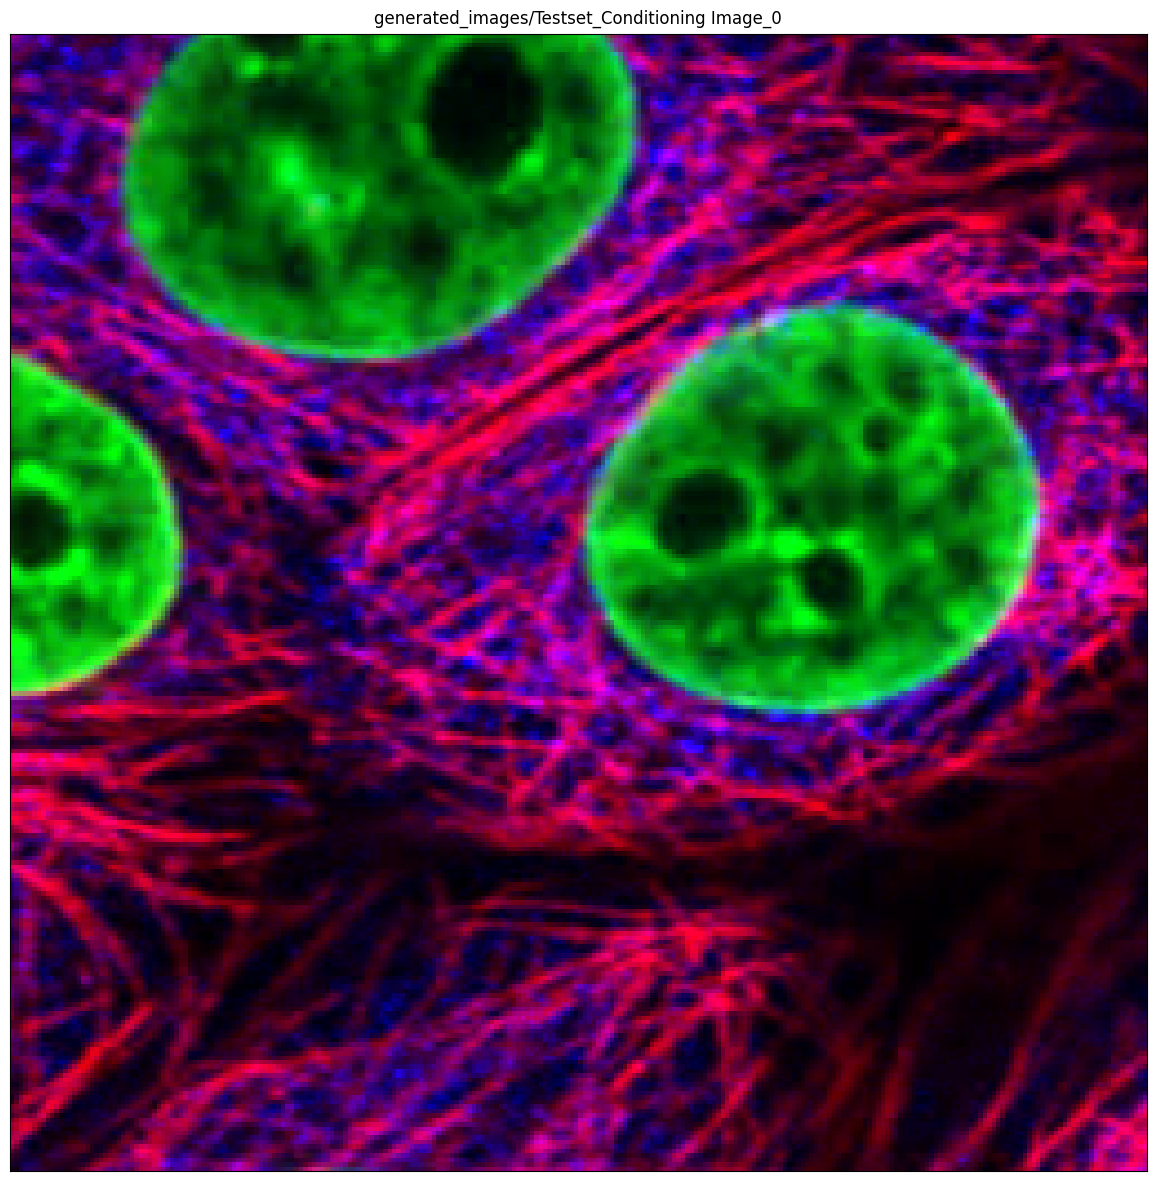

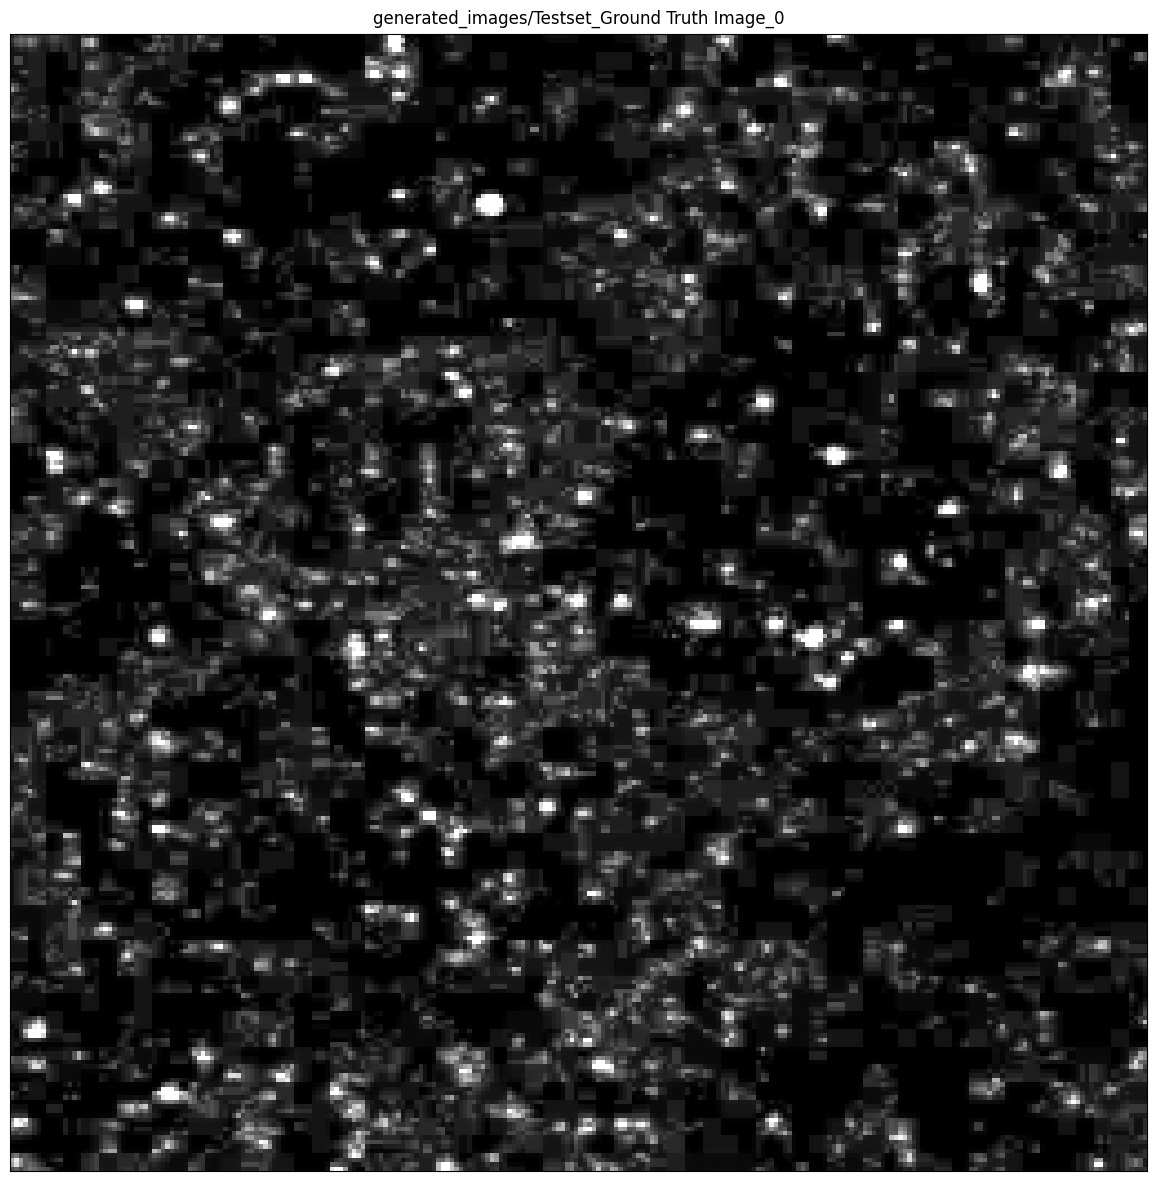

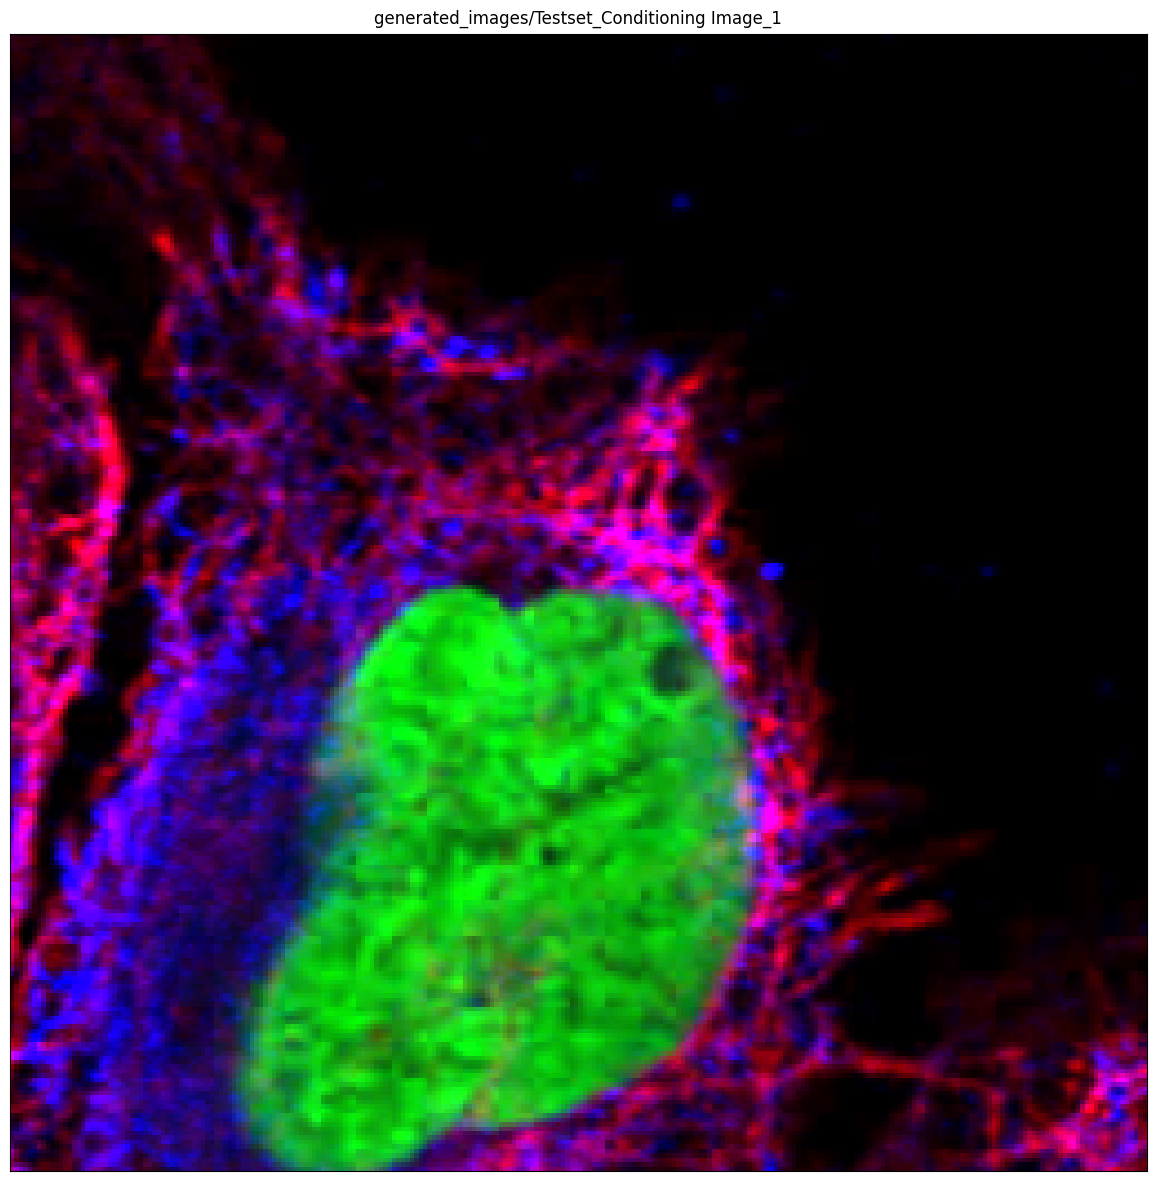

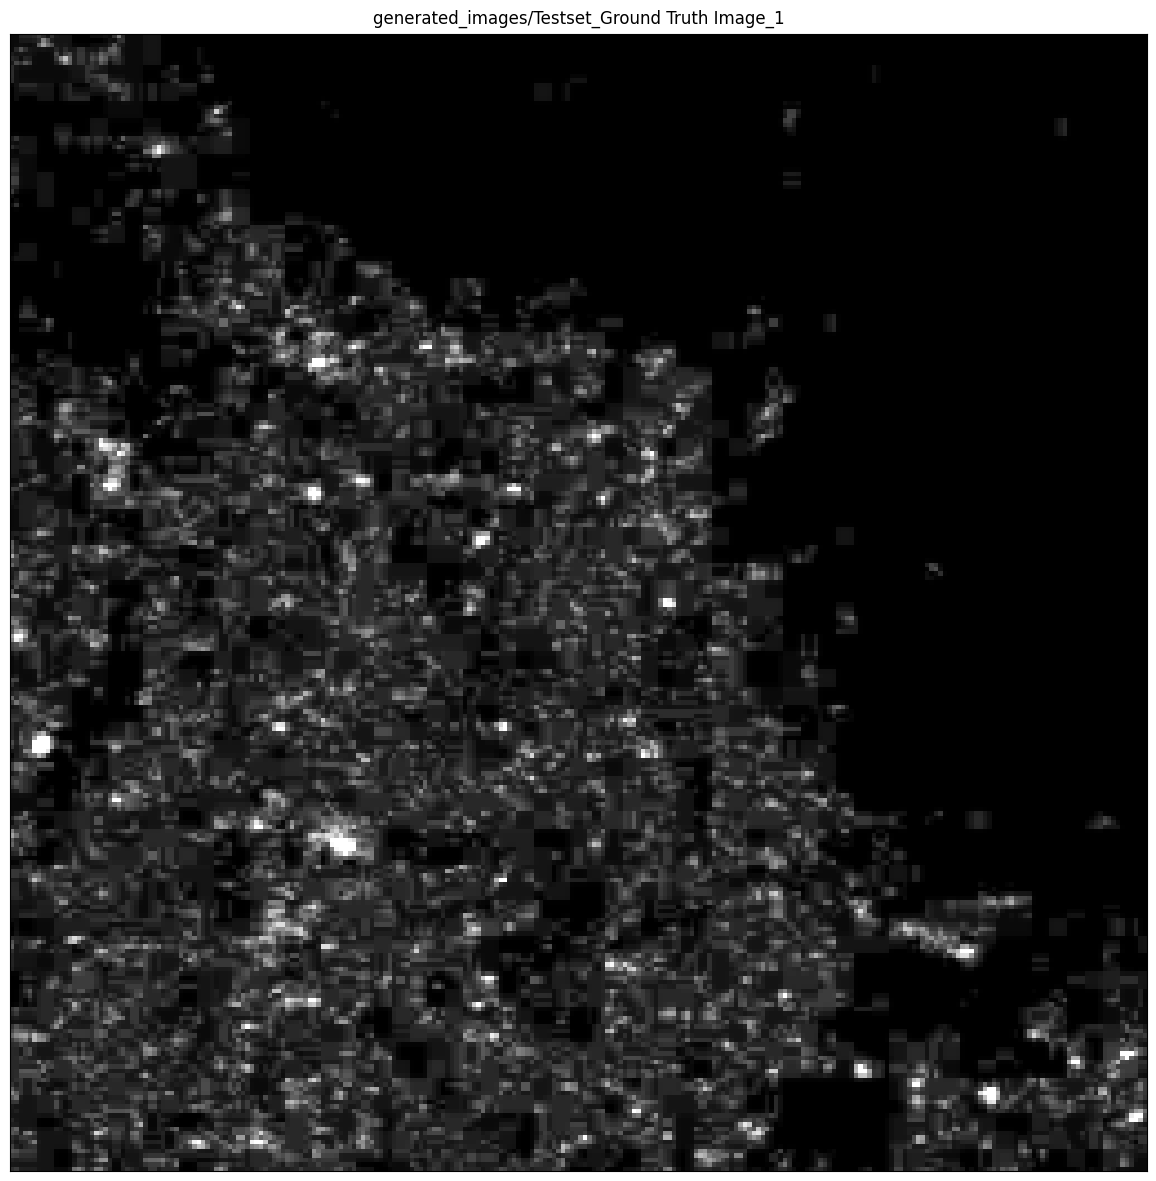

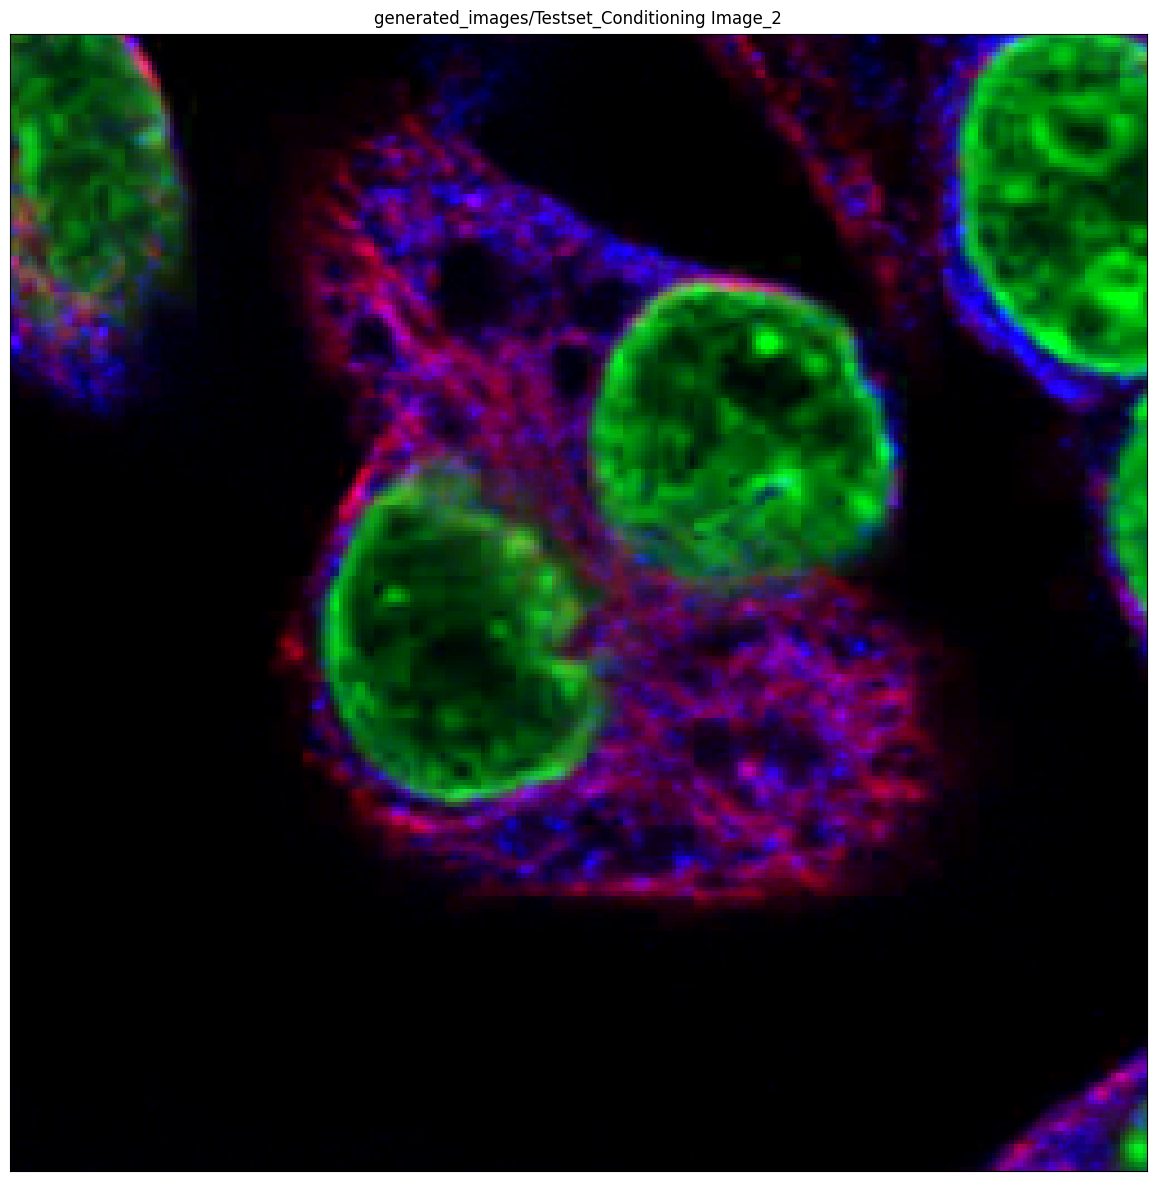

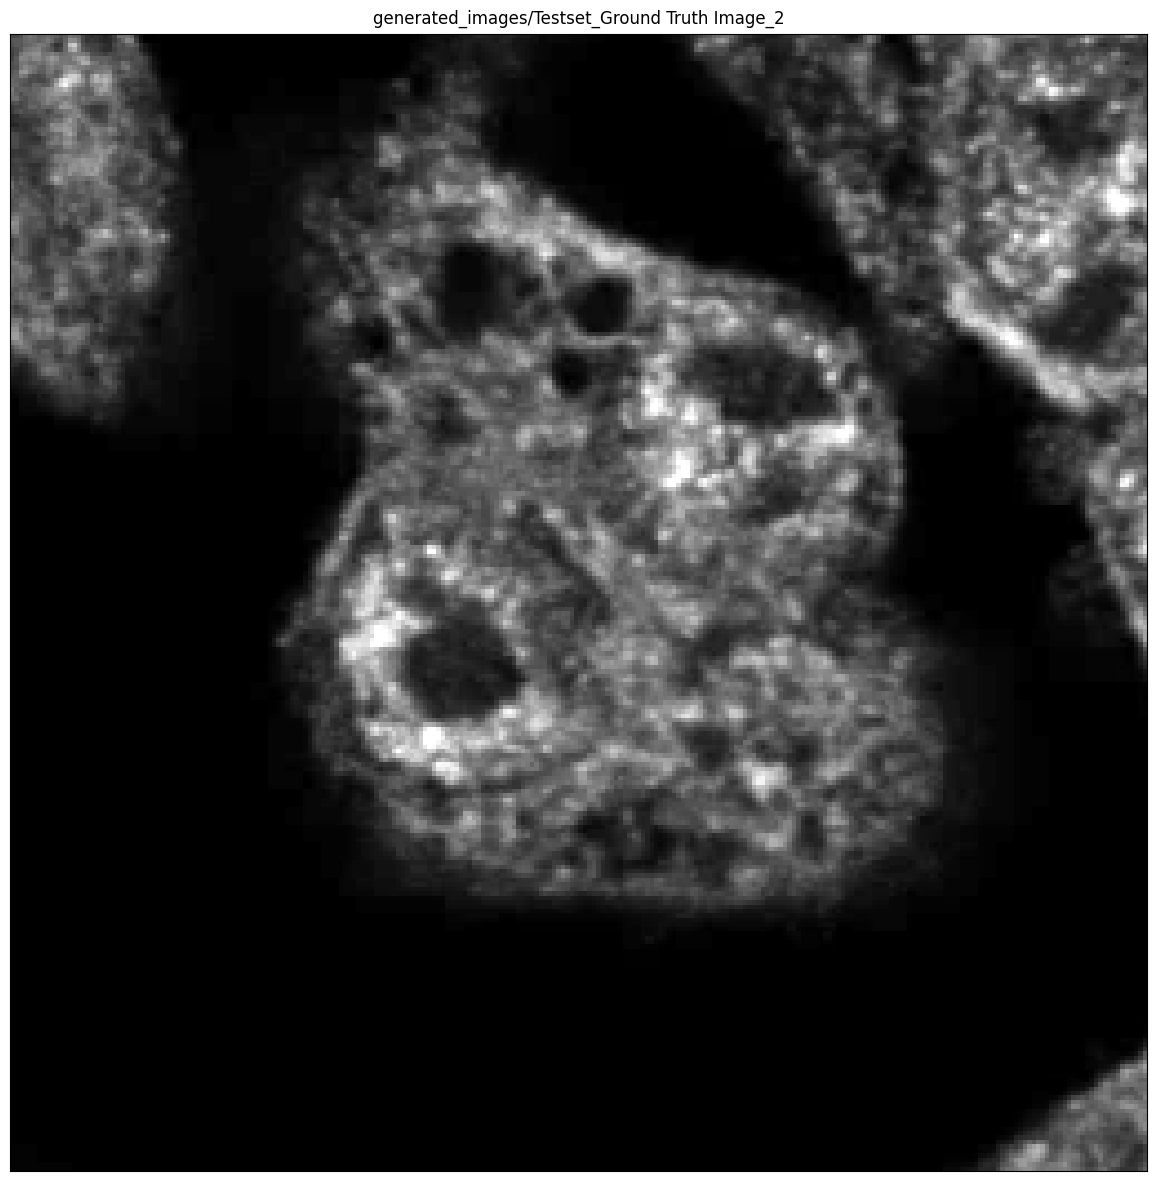

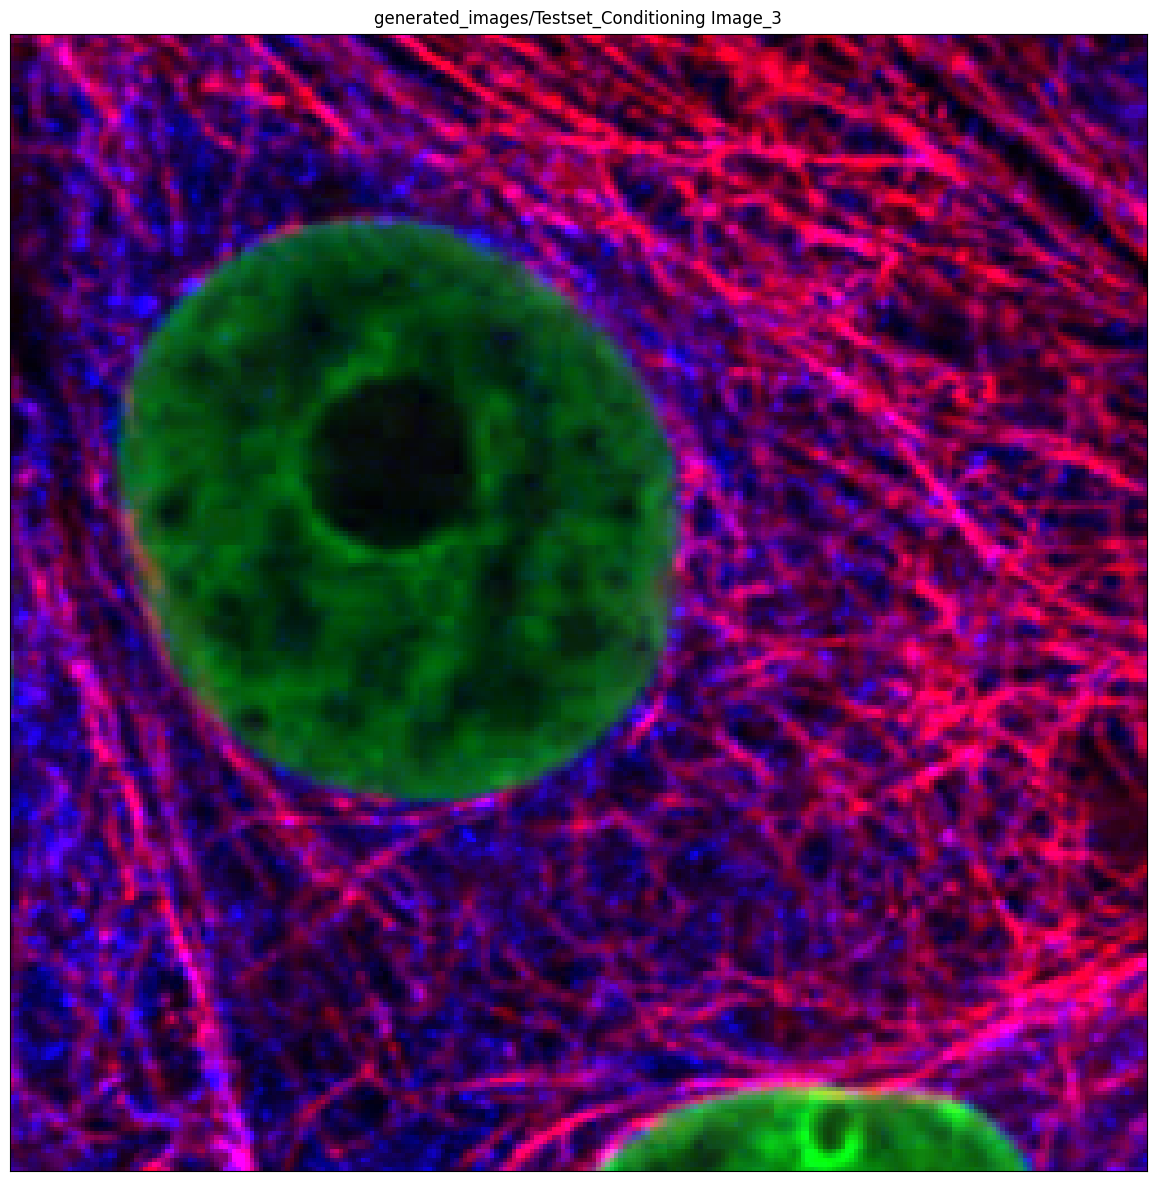

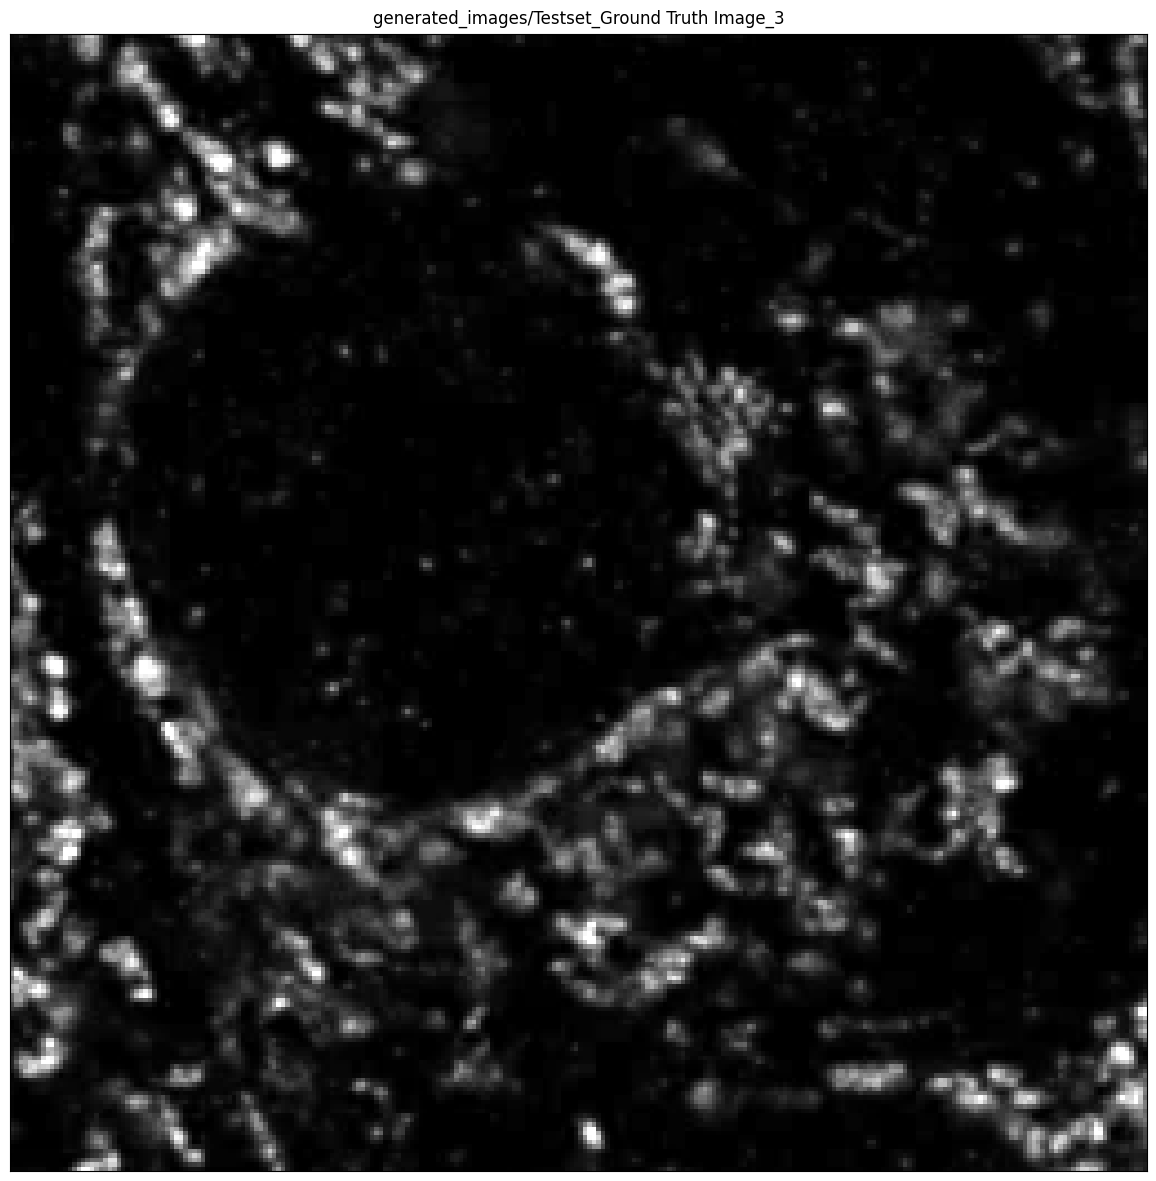

In [5]:
# Load a test dataset to get real conditioning images
try:
    test_dataset = FullFieldDataset(
        data_root='/home/pc/Documents/twisted_diffusion_helper_model/test_images',
        label_dict='/home/pc/Documents/twisted_diffusion_helper_model/antibody_map.pkl',
        annotation_dict='/home/pc/Documents/twisted_diffusion_helper_model/annotation_map.pkl'
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=4, 
        shuffle=True,
    )
    # Get a batch of test data
    batch = next(iter(test_dataloader))
    
    # Show conditioning image
    cond_images = batch["cond_image"].to(weight_dtype).to(device)
    clip_images = batch["clip_image"].to(weight_dtype).to(device)
    gt_images = batch["gt_image"].to(weight_dtype).to(device)
    # Encode conditioning image to latent space
    with torch.no_grad():
        #cond_images_latent = prepare_latent_sample(vae, cond_images.repeat(1, 3, 1, 1), weight_dtype)
        encoder_hidden_states = clip_model(clip_images)
        
    # Prepare cell_line and label conditioning
    cell_line = batch["cell_line"].to(device).long()
    label = batch["label"].to(device).long()
    #one hot encoding
    cell_line = torch.nn.functional.one_hot(cell_line, num_classes=40)
    label = torch.nn.functional.one_hot(label, num_classes=13348)
    
    total_label = torch.cat([cell_line, label], dim=1)
    
    # Display conditioning image
    for i in range(batch_size):
        plot_images(cond_images[i].cpu().float()*0.5+0.5, row_title=f"generated_images/Testset_Conditioning Image_{i}")
        plot_images(gt_images[i].cpu().float()*0.5+0.5, row_title=f"generated_images/Testset_Ground Truth Image_{i}")
    
except Exception as e:
    print(f"Could not load test dataset: {e}")
    print("Generating without real conditioning images...")
    
    # Create random conditioning
    batch_size = 4
    
    # Random latent for conditioning (using 8 channels for conditioning)
    cond_images_latent = torch.randn(
        (batch_size, 8, image_size, image_size),
        device=device, 
        dtype=weight_dtype
    )
    
    # Random CLIP embeddings
    encoder_hidden_states = torch.randn(
        (batch_size, 196, 768),
        device=device,
        dtype=weight_dtype
    )
    
    # Create a one-hot vector for cell line (assuming 40 cell lines)
    cell_line = torch.zeros((batch_size, 40), device=device, dtype=weight_dtype)
    cell_line[:, 0] = 1.0  # Set first cell line
    
    # Create a one-hot vector for protein label (assuming 13348 labels)
    label = torch.zeros((batch_size, 13348), device=device, dtype=weight_dtype)
    label[:, 0] = 1.0  # Set first label
    
    total_label = torch.cat([cell_line, label], dim=1)

In [6]:
def sample_edm(
    model,
    scheduler,
    batch_size=1,
    image_size=32,
    num_inference_steps=50,
    condition_latent=None,  # Optional conditioning latent
    encoder_hidden_states=None,  # CLIP hidden states
    class_labels=None,  # Class labels for conditioning
    guidance_scale=1.0,  # Scale for classifier-free guidance
    generator=None,
    output_type="latent",  # "latent" or "pt"
):
    """Sample from the diffusion model using EDM sampling"""
    # Initialize with random noise for the ground truth part
    if condition_latent is not None:
        latent_channels = 32 - condition_latent.shape[1]  # Get channels for gt part
    else:
        latent_channels = 32
        condition_latent = torch.zeros((batch_size, 0, image_size, image_size), device=device, dtype=weight_dtype)
    
    # Create random noise for the ground truth part
    gt_noise = torch.randn(
        (batch_size, latent_channels, image_size, image_size),
        generator=generator,
        device=device,
        dtype=weight_dtype
    )
    
    # Initialize with random noise * sigma_max for the ground truth part
    latents = gt_noise * scheduler.sigmas[0].to(device)
    
    # Set up classifier-free guidance conditioning (if needed)
    do_classifier_free_guidance = guidance_scale > 1.0
    
    # Set up progress bar
    progress_bar = tqdm(range(num_inference_steps))
    progress_bar.set_description("Sampling")
    
    # Set timesteps for sampling
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps
    
    # Sampling loop
    for i, t in enumerate(progress_bar):
        # Get sigma for this step
        sigma = scheduler.sigmas[i]
        sigma_next = scheduler.sigmas[i + 1] if i < len(scheduler.sigmas) - 1 else torch.tensor(0.0, device=device)
        
        # Expand sigma for broadcasting
        sigma_expanded = sigma.expand(batch_size).to(device)
        sigma_view = sigma_expanded.view(-1, 1, 1, 1).double()
        
        
        latents = latents.double()
        
        # Combine latents with condition latent
        #combined_latent = torch.cat([latents, condition_latent], dim=1)
        combined_latent = latents
        # Prepare input with noise according to EDM formulation
        model_input, timestep_input = edm_clean_image_to_model_input(combined_latent, sigma_view)
        timestep_input = timestep_input.squeeze()
        
        # For classifier-free guidance, we need to do two forward passes:
        # one with the conditioning and one without
        if do_classifier_free_guidance:
            # Unconditional forward pass
            model_output_uncond = model(
                model_input,
                timestep_input,
                class_labels=None,  # No class conditioning
                encoder_hidden_states=None,  # No CLIP conditioning
            ).sample
            
            # Conditional forward pass
            model_output_cond = model(
                model_input,
                timestep_input,
                class_labels=class_labels,
                encoder_hidden_states=encoder_hidden_states,
            ).sample
            
            # Combine outputs with guidance scale
            model_output = model_output_uncond + guidance_scale * (model_output_cond - model_output_uncond)
        else:
            # Regular conditional forward pass
            model.to(weight_dtype)
            model_input = model_input.to(weight_dtype)
            timestep_input = timestep_input.to(weight_dtype)
            class_labels = class_labels.to(weight_dtype)
            encoder_hidden_states = encoder_hidden_states.to(weight_dtype)
            model_output = model(
                model_input,
                timestep_input,
                class_labels=class_labels,
                encoder_hidden_states=encoder_hidden_states,
            ).sample
        
        # Convert model output to denoised latent (x0 prediction)
        pred_x0 = edm_model_output_to_x_0_hat(combined_latent, sigma_view, model_output.double())
        
        # Extract only the ground truth part (not the conditioning part)
        #pred_x0 = pred_x0[:, :latent_channels, :, :]

        # Step using the scheduler
        # We implement a simplified Euler step for the EDM sampler
        denoised = pred_x0
        step_sigma = sigma - sigma_next
        step_size = step_sigma / sigma
        
        # Calculate D(xt) (denoised - noisy) / sigma as the "direction"
        direction = (denoised - latents) / sigma_view
        
        # Euler step
        latents = latents + step_size.item() * sigma_view * direction
        
        # Add noise if not the last step
        if i < num_inference_steps - 1:
            noise = torch.randn_like(latents)
            latents = latents + ((sigma_next**2 - sigma_next**2) ** 0.5) * noise
    
    # Return the final latents or decode to images based on output_type
    if output_type == "latent":
        return latents
    elif output_type == "pt":
        # Return PyTorch tensor
        return latents
    else:
        raise ValueError(f"Unsupported output_type: {output_type}")

In [8]:
# Generate samples
weight_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32
num_inference_steps=1000
with torch.no_grad():
    # Set random seed for reproducibility
    generator = torch.Generator(device=device).manual_seed(42)
    
    # Sample from the model
    generated_latents = sample_edm(
        model=model,
        scheduler=scheduler,
        batch_size=batch_size,
        image_size=image_size,
        num_inference_steps=num_inference_steps,
        condition_latent=None,
        encoder_hidden_states=encoder_hidden_states,
        class_labels=total_label,
        guidance_scale=0,
        generator=generator,
        output_type="latent",
    )
    
    # Decode the latents to images
    vae.to(torch.float32)
    generated_latents = generated_latents.to(torch.float32)
    generated_images_gt = decode_latents(vae, generated_latents[:,:16,:,:])
    generated_images_cond = decode_latents(vae, generated_latents[:,16:,:,:])
    
print(f"Generated {len(generated_images_gt)} images")

Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 80.27it/s]

Generated 4 images



/tmp/ipykernel_933463/2593660454.py:27: FutureWarning: Accessing config attribute `scaling_factor` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'scaling_factor' over 'AutoencoderKL's config object instead, e.g. 'unet.config.scaling_factor'.
  latents = latents * 4 / vae.scaling_factor


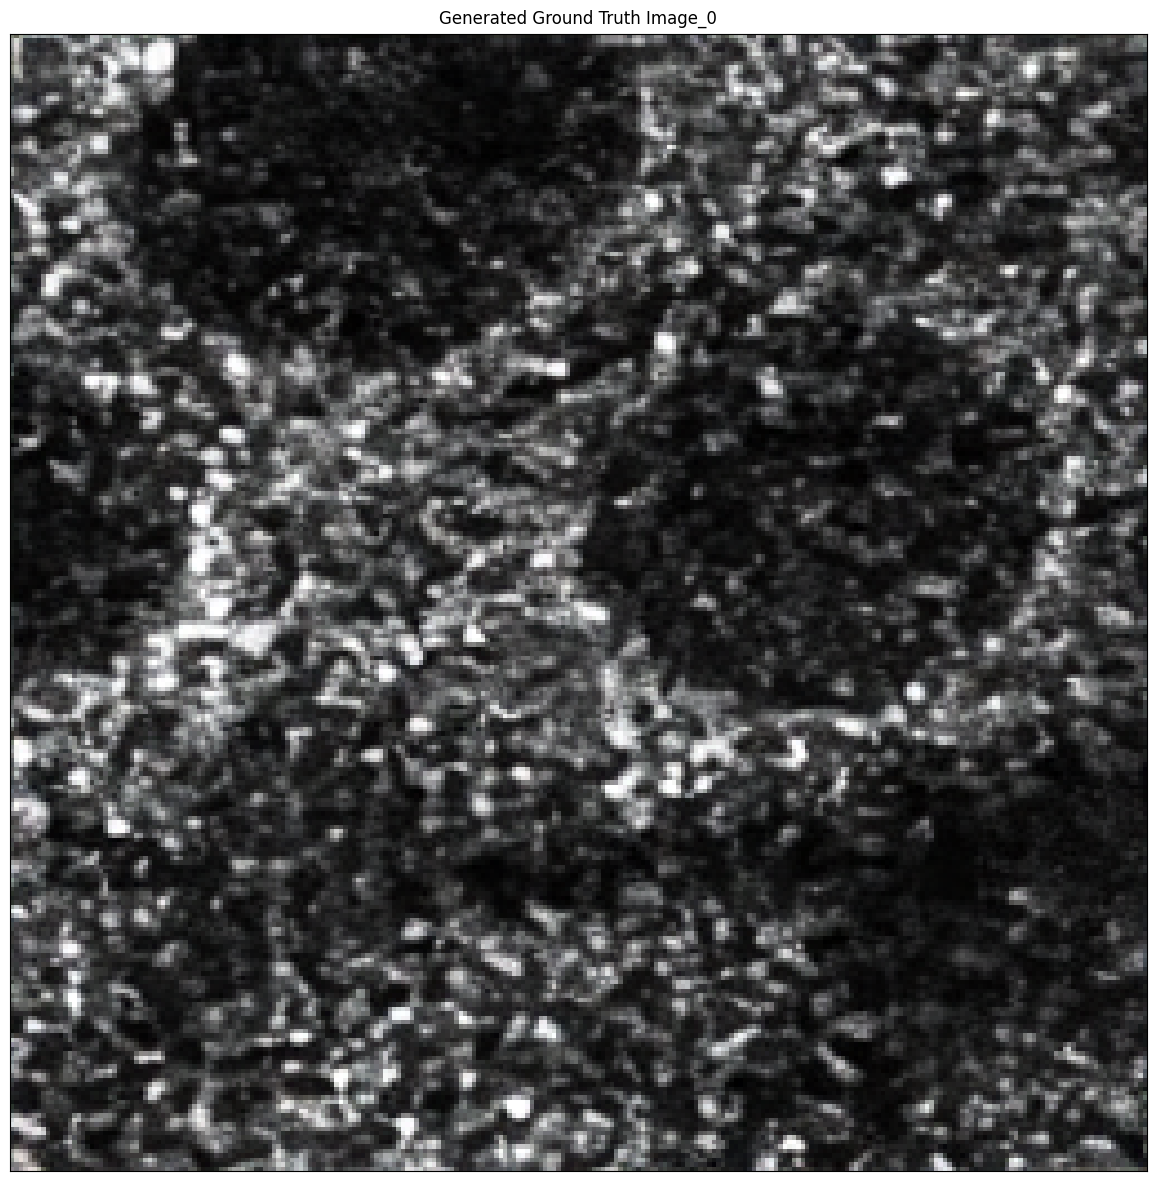

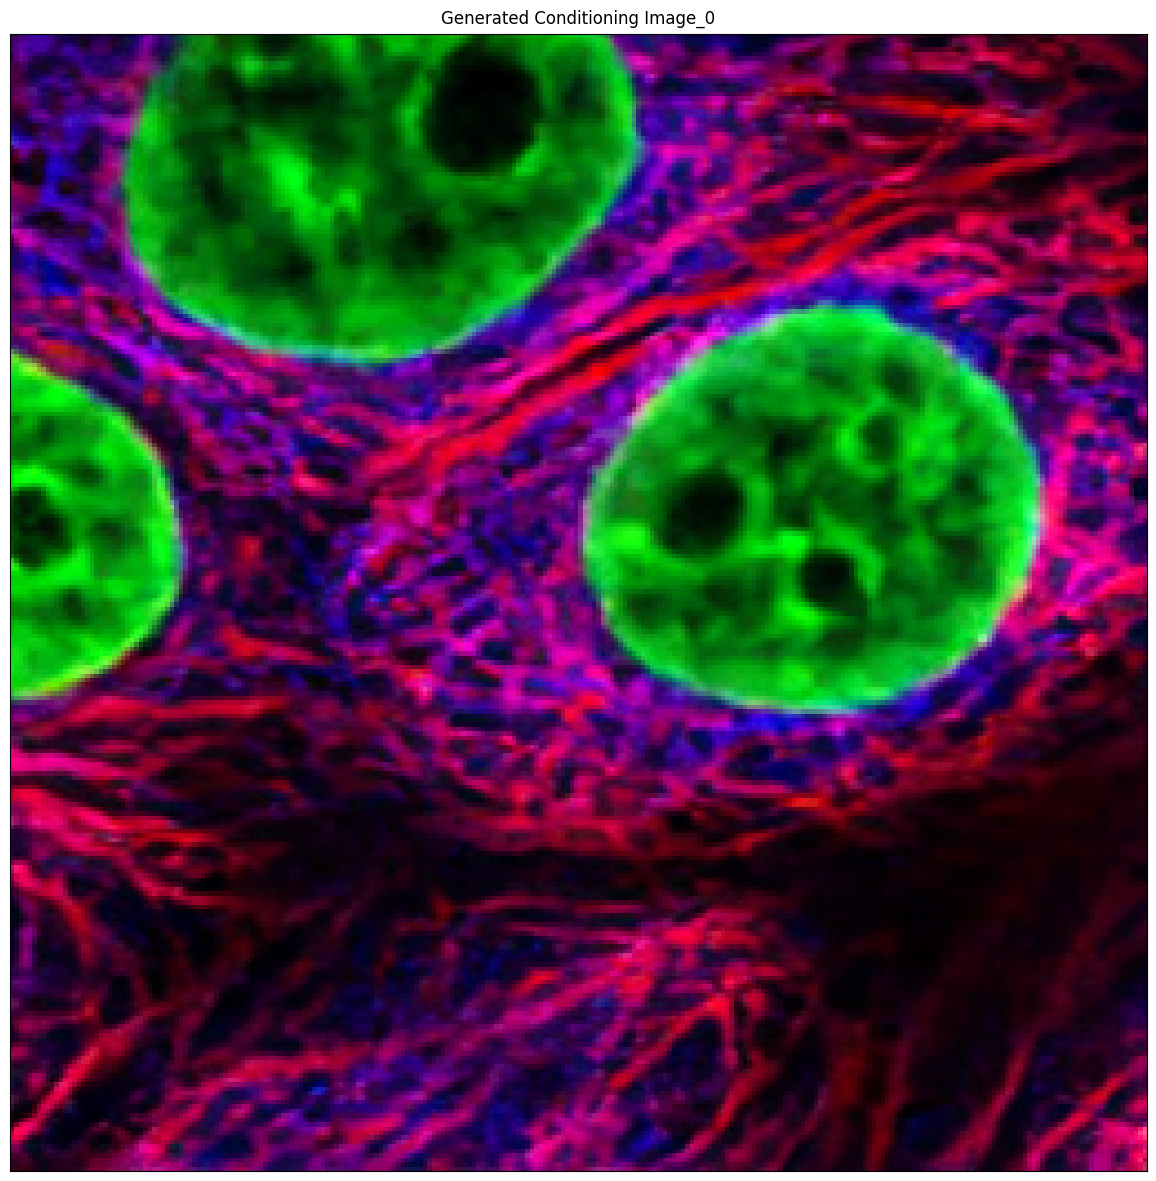

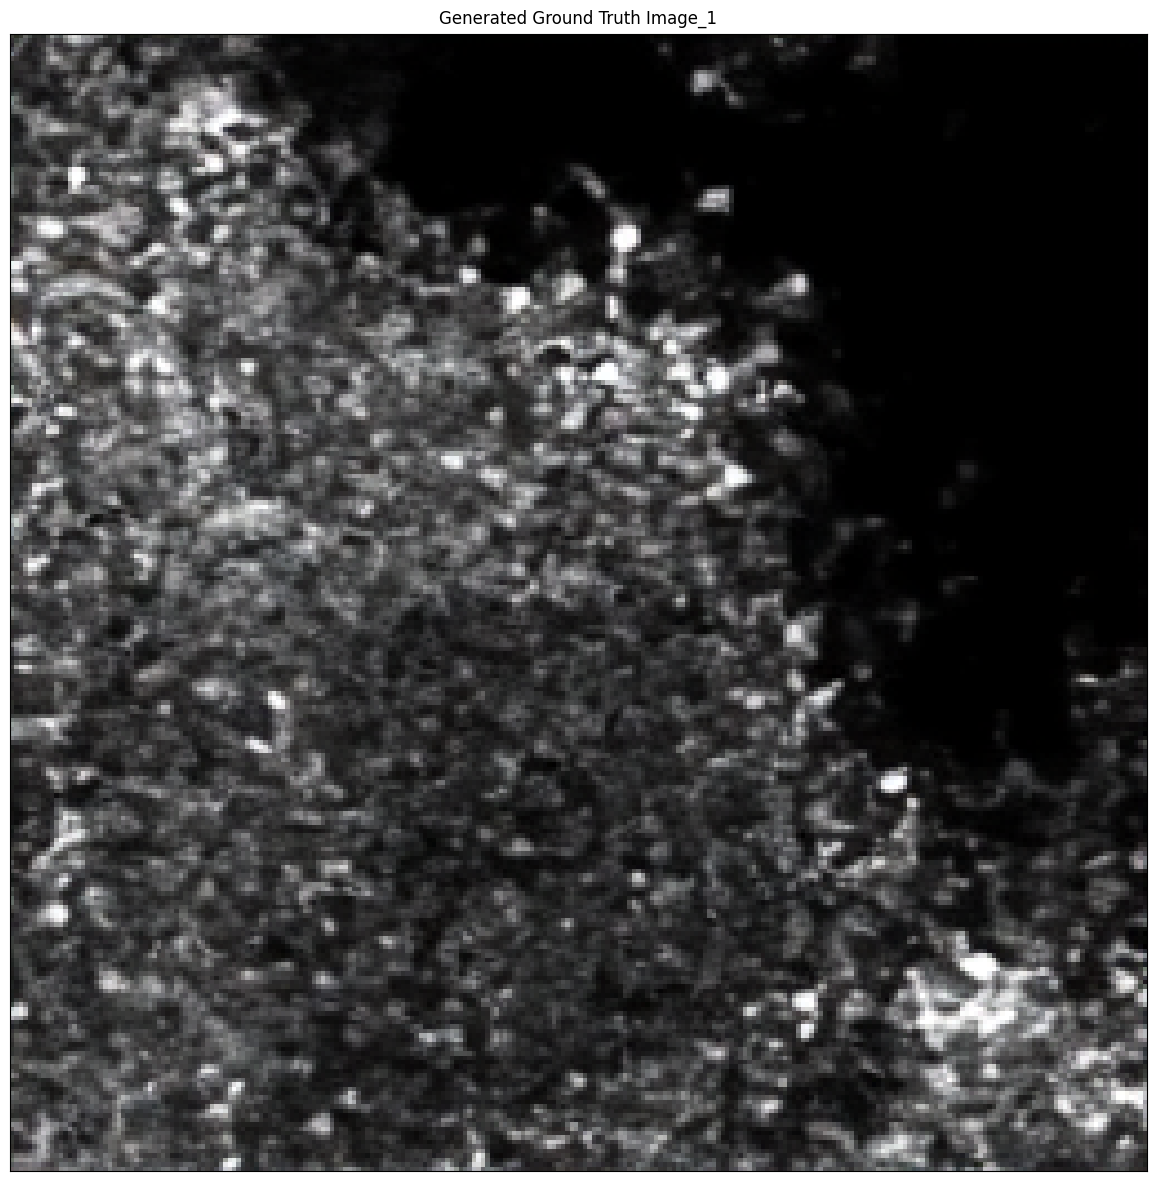

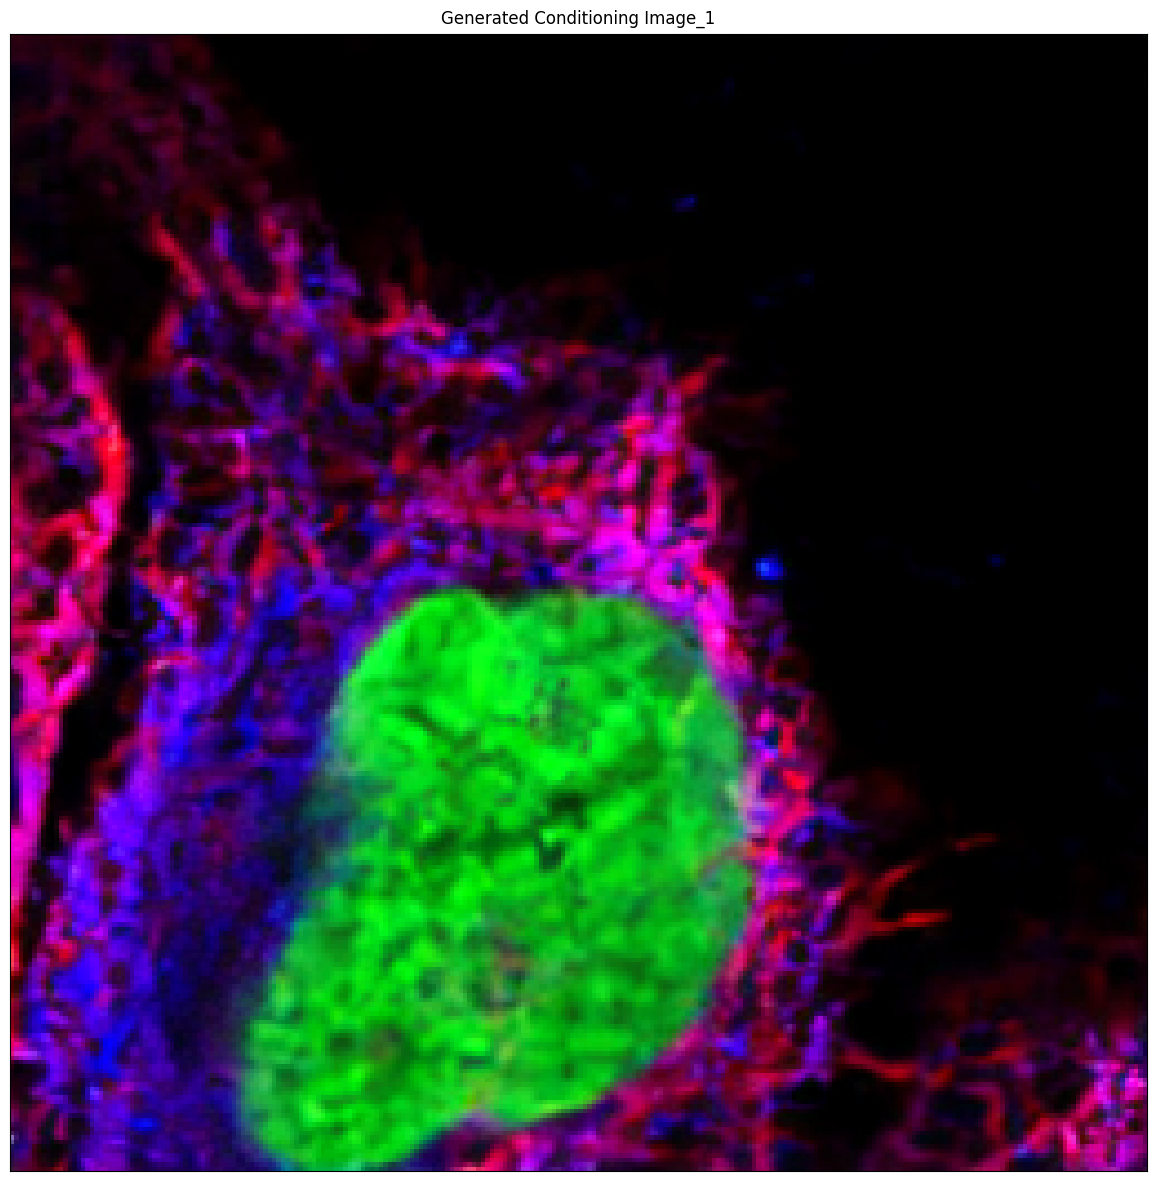

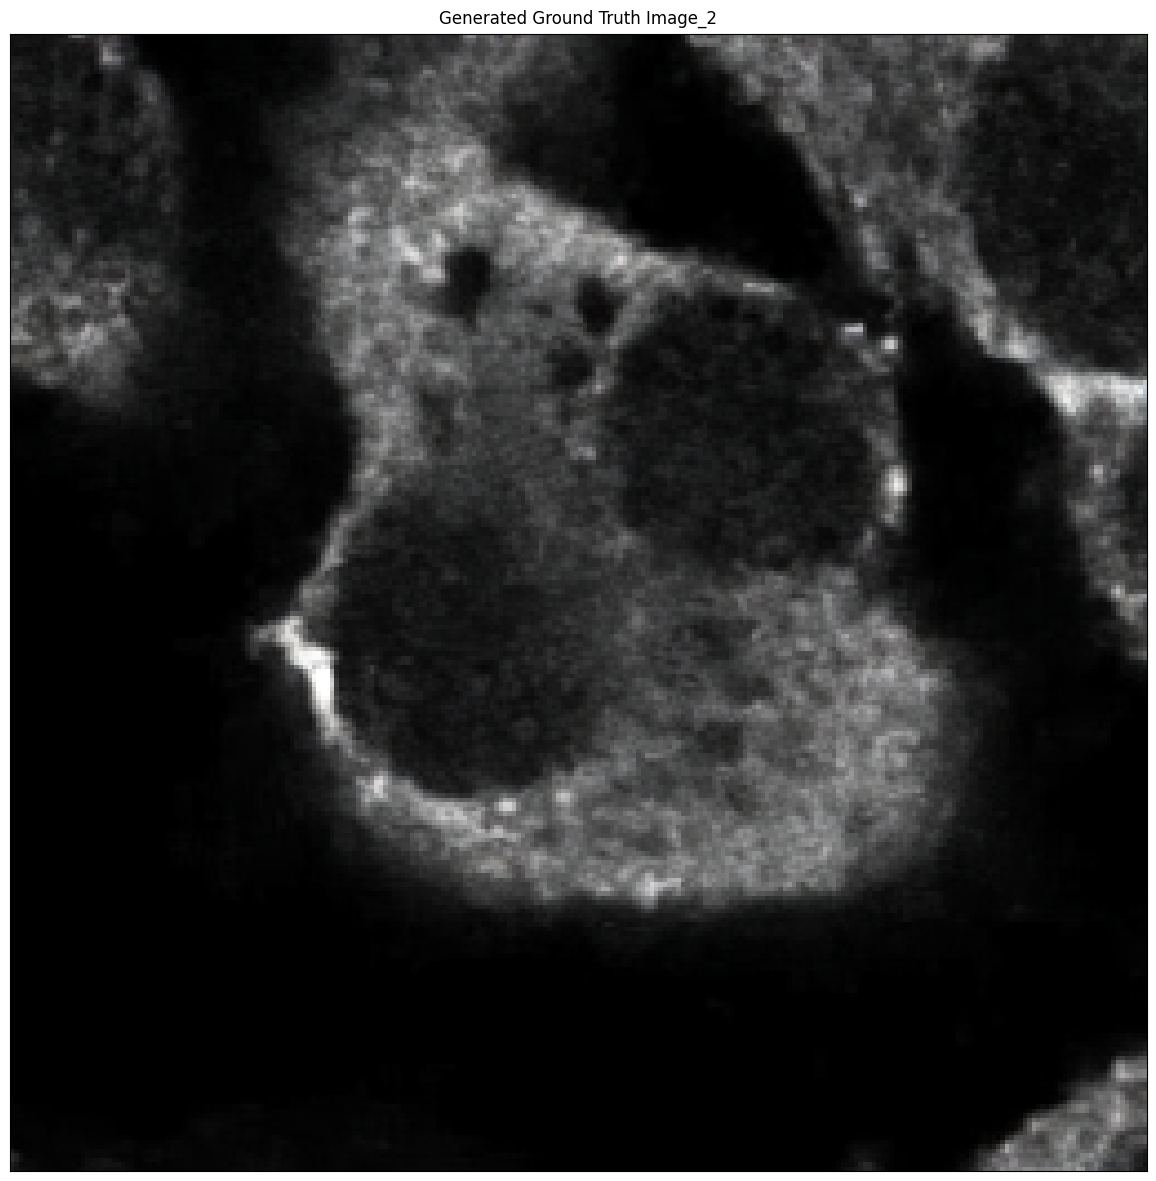

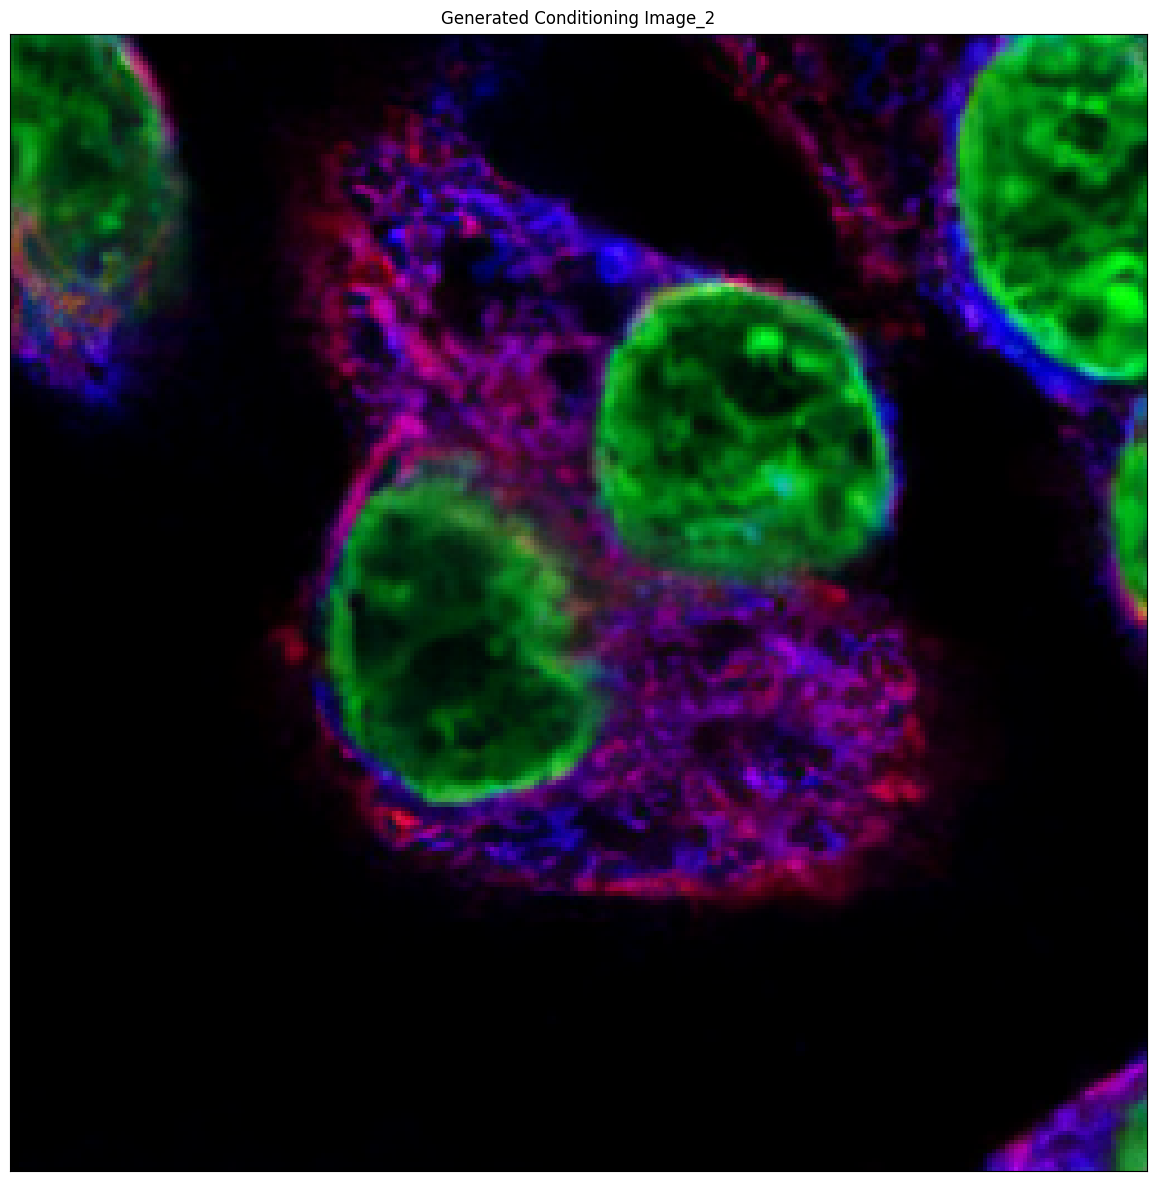

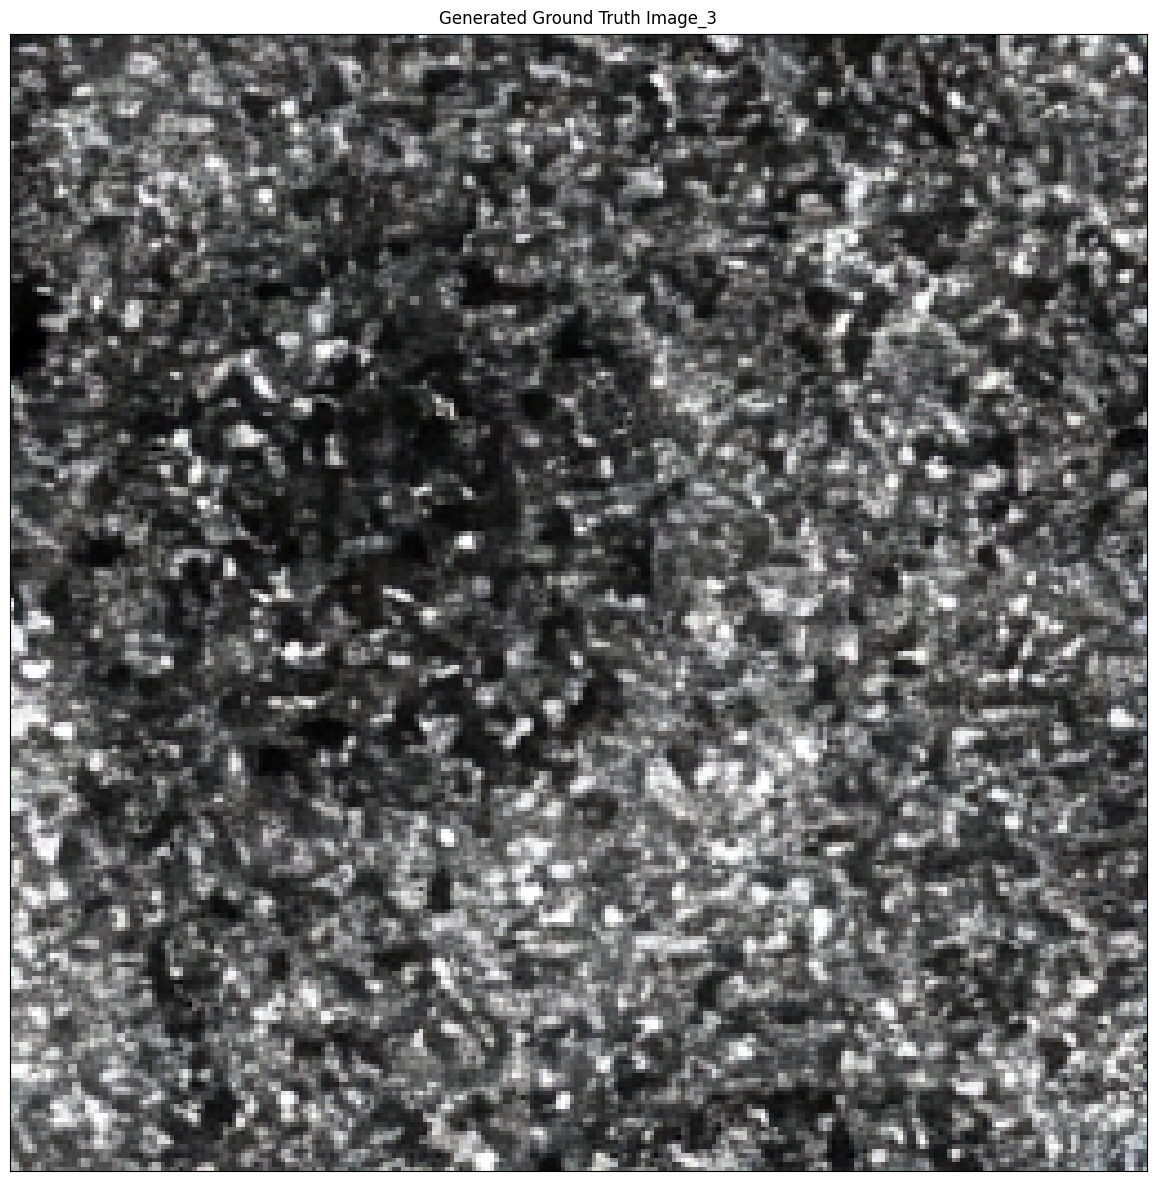

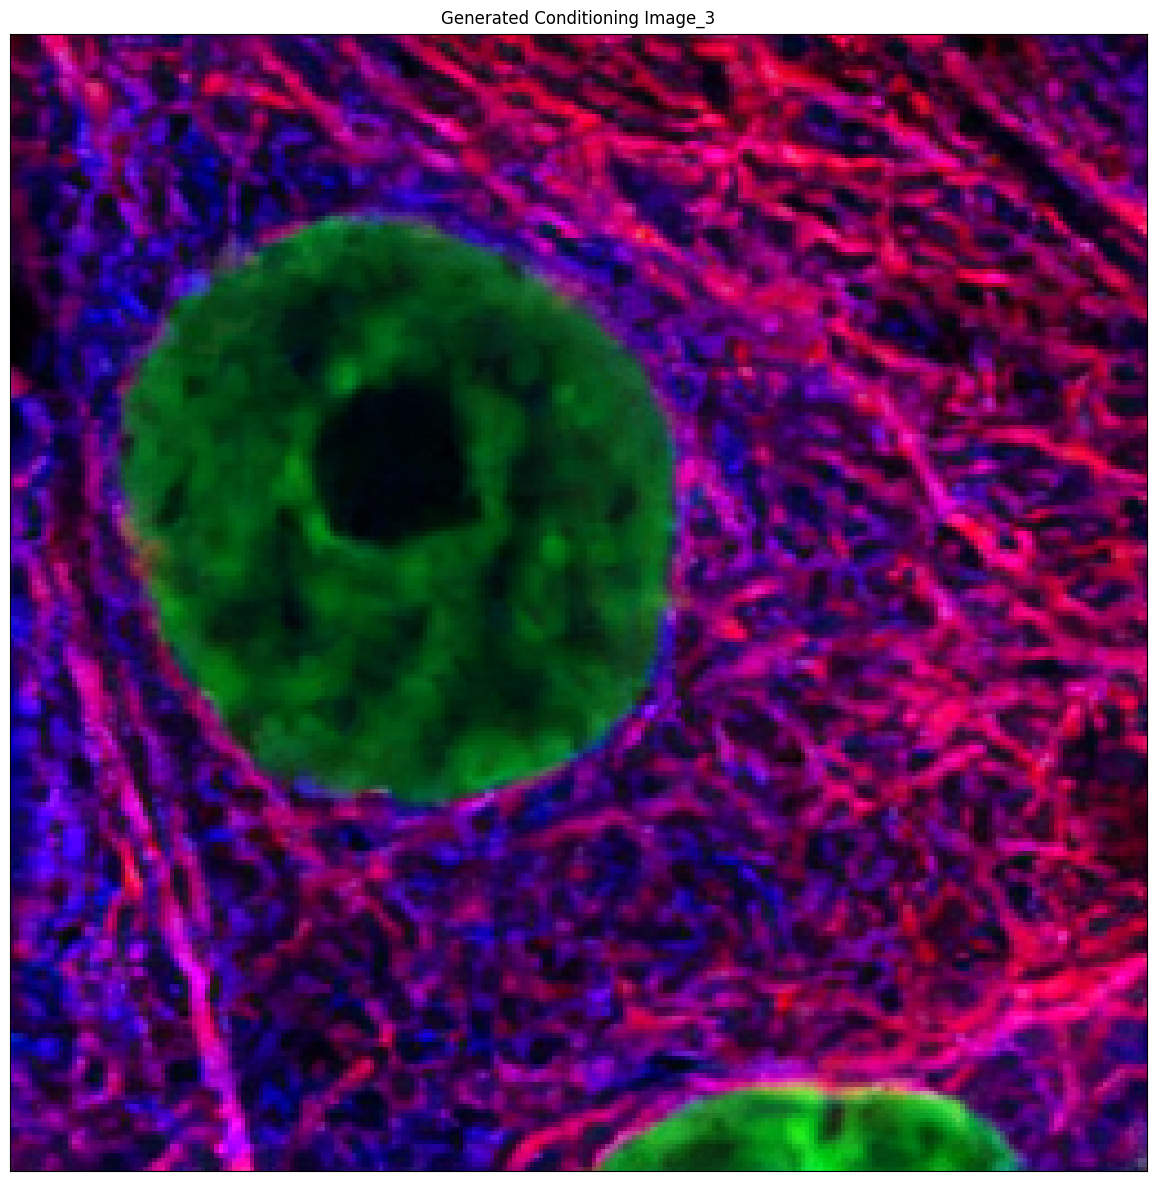

In [9]:
# Display the generated images
for i, img in enumerate(generated_images_gt):
    plot_images(generated_images_gt[i].cpu(), row_title=f"Generated Ground Truth Image_{i}")
    plot_images(generated_images_cond[i].cpu(), row_title=f"Generated Conditioning Image_{i}")

## Batch Generation with Different Parameters

In [9]:
def generate_with_parameters(
    num_images=4,
    guidance_scales=[1.0, 3.0, 5.0, 7.0],
    num_inference_steps=50,
    random_seed=42,
):
    """Generate multiple images with different parameters"""
    all_images = []
    
    # Setup conditioning if not already defined
    if 'cond_images_latent' not in globals():
        # Create random conditioning
        cond_images_latent = torch.randn(
            (num_images, 8, image_size, image_size),
            device=device, 
            dtype=weight_dtype
        )
        
        # Random CLIP embeddings
        encoder_hidden_states = torch.randn(
            (num_images, 196, 768),
            device=device,
            dtype=weight_dtype
        )
        
        # Create a one-hot vector for cell line (assuming 40 cell lines)
        cell_line = torch.zeros((num_images, 40), device=device, dtype=weight_dtype)
        cell_line[:, 0] = 1.0  # Set first cell line
        
        # Create a one-hot vector for protein label (assuming 13348 labels)
        label = torch.zeros((num_images, 13348), device=device, dtype=weight_dtype)
        label[:, 0] = 1.0  # Set first label
        
        total_label = torch.cat([cell_line, label], dim=1)
    else:
        # Use globally defined conditioning
        pass
    
    # Generate samples with different guidance scales
    for guidance_scale in guidance_scales:
        with torch.no_grad():
            # Set random seed for reproducibility
            generator = torch.Generator(device=device).manual_seed(random_seed)
            
            # Sample from the model
            latents = sample_edm(
                model=model,
                scheduler=scheduler,
                batch_size=num_images,
                image_size=image_size,
                num_inference_steps=num_inference_steps,
                condition_latent=cond_images_latent,
                encoder_hidden_states=encoder_hidden_states,
                class_labels=total_label,
                guidance_scale=guidance_scale,
                generator=generator,
                output_type="latent",
            )
            
            # Decode the latents to images
            images = decode_latents(vae, latents)
            
            all_images.append({"guidance_scale": guidance_scale, "images": images})
    
    # Plot images with different guidance scales
    num_rows = len(all_images)
    num_cols = num_images
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    
    for row_idx, result in enumerate(all_images):
        guidance_scale = result["guidance_scale"]
        images = result["images"]
        
        for col_idx, img in enumerate(images):
            if isinstance(img, torch.Tensor):
                img = img.detach().cpu().numpy()
            
            # Handle different shapes and channel configurations
            if img.ndim == 4 and img.shape[0] == 1:  # [1, C, H, W]
                img = img[0]
            
            if img.shape[0] == 3 or img.shape[0] == 1:  # [C, H, W]
                img = img.transpose(1, 2, 0)
            
            if img.shape[-1] == 1:  # Single channel
                img = img.squeeze(-1)
                axs[row_idx, col_idx].imshow(img, cmap='gray')
            else:  # RGB
                axs[row_idx, col_idx].imshow(img)
            
            axs[row_idx, col_idx].set_xticks([])
            axs[row_idx, col_idx].set_yticks([])
            
            if col_idx == 0:
                axs[row_idx, col_idx].set_ylabel(f"CFG: {guidance_scale}")
    
    plt.tight_layout()
    plt.show()

In [10]:
# Generate images with different guidance scales
generate_with_parameters(
    num_images=4,
    guidance_scales=[1.0, 3.0, 5.0, 7.0],
    num_inference_steps=30,  # Faster sampling for demonstration
    random_seed=42,
)

Sampling:   0%|          | 0/30 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [256, 32, 3, 3], expected input[4, 24, 32, 32] to have 32 channels, but got 24 channels instead

## Save Generated Images

In [ ]:
def save_images(images, output_dir="generated_images", prefix="sample", format="png"):
    """Save generated images to disk"""
    from PIL import Image
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    for i, img in enumerate(images):
        if isinstance(img, torch.Tensor):
            img = (img * 255).clamp(0, 255).cpu().numpy().astype(np.uint8)
        
        # Convert from [C, H, W] to [H, W, C]
        if img.shape[0] == 3 or img.shape[0] == 1:
            img = img.transpose(1, 2, 0)
        
        # Remove single-dimension channel for grayscale
        if img.shape[-1] == 1:
            img = img.squeeze(-1)
        
        # Convert to PIL Image
        pil_img = Image.fromarray(img)
        
        # Save image
        file_path = os.path.join(output_dir, f"{prefix}_{i:04d}.{format}")
        pil_img.save(file_path)
        print(f"Saved {file_path}")

In [ ]:
# Save the generated images
save_images(generated_images, output_dir="generated_images", prefix="edm_sample")